In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/hw3_speech_files/

/content/drive/MyDrive/hw3_speech_files


In [3]:
ls

cc_001_anxiety_910.77_May-twenty-third.wav
cc_001_anxiety_916.11_Eight-hundred-eight.wav
cc_001_anxiety_918.66_Eight-hundred-eight.wav
cc_001_anxiety_928.48_Four-thousand-eight.wav
cc_001_anxiety_934.73_Nine-thousand-six.wav
cc_001_anxiety_940.56_Nine-thousand-six.wav
cc_001_anxiety_957.85_Six-thousand-twelve.wav
cc_001_anxiety_961.15_Six-thousand-twelve.wav
cc_001_anxiety_968.16_Three-thousand-eight.wav
cc_001_anxiety_974.76_Three-thousand-eight.wav
cc_001_boredom_2221.42_April-fifteenth.wav
cc_001_boredom_2227.39_April-fifteenth.wav
cc_001_boredom_2235.64_March-twenty-sixth.wav
cc_001_boredom_2239.45_March-twenty-sixth.wav
cc_001_boredom_2243.67_October-sixth.wav
cc_001_boredom_2248.50_Eight-thousand-six.wav
cc_001_boredom_2252.08_Eight-thousand-six.wav
cc_001_boredom_2258.71_Five-thousand-twelve.wav
cc_001_boredom_2264.52_Nine-hundred-four.wav
cc_001_boredom_2266.98_Nine-hundred-four.wav
cc_001_boredom_2278.62_Six-hundred-six.wav
cc_001_boredom_2281.93_Six-hundred-six.wav
cc_001_bor

In [4]:
pip install --upgrade praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 102.3 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import parselmouth
from parselmouth.praat import call
import seaborn as sns
from glob import glob
from tqdm import tqdm

#speech files path
SPEECH_FILES_PATH = "/content/drive/MyDrive/hw3_speech_files/"

speaker_raw_pitch_values = {}
speaker_raw_intensity_values = {}

# extract pitch and intensity (6 features) for every speaker
for audio_file in tqdm(glob(os.path.join(SPEECH_FILES_PATH, "*.wav"))):
    try:
        #get speaker name
        filename = os.path.basename(audio_file)
        parts = filename.split('_')
        speaker_id = parts[0]

        #create empty list for each new speaker
        if speaker_id not in speaker_raw_pitch_values:
            speaker_raw_pitch_values[speaker_id] = []
            speaker_raw_intensity_values[speaker_id] = []

        #extract left channel (1)
        full_sound = parselmouth.Sound(audio_file)
        sound = full_sound.extract_channel(1)

        #pitch extraction
        #pitch range: 75-600HZ
        pitch = call(sound, "To Pitch (ac)", 0.0,  75, 15, "off", 0.03, 0.45, 0.01, 0.35, 0.14, 600)
        pitch_values = np.asarray(pitch.selected_array["frequency"])
        valid_pitch = pitch_values[(pitch_values > 0) & ~np.isnan(pitch_values)]
        speaker_raw_pitch_values[speaker_id].extend(valid_pitch)

        #intensity extraction
        #intensity pitch floor 75HZ
        intensity = call(sound, "To Intensity", 75, 0.0, "yes")
        intensity_values = np.asarray(intensity.values[0])
        valid_intensity = intensity_values[(intensity_values > 0) & ~np.isnan(intensity_values)]
        speaker_raw_intensity_values[speaker_id].extend(valid_intensity)

    except Exception as e:
        print(f"error for {audio_file}: {e}")

100%|██████████| 2324/2324 [01:29<00:00, 26.02it/s] 


In [6]:
#get overall mean and std pitch of speaker cc
speaker_statistics = {}

for speaker_id in speaker_raw_pitch_values.keys():
    speaker_statistics[speaker_id] = {
        'pitch_mean': np.mean(speaker_raw_pitch_values[speaker_id]),
        'pitch_std': np.std(speaker_raw_pitch_values[speaker_id]),
        'intensity_mean': np.mean(speaker_raw_intensity_values[speaker_id]),
        'intensity_std': np.std(speaker_raw_intensity_values[speaker_id])
    }
    print(f"speaker: {speaker_id}, stats: {speaker_statistics[speaker_id]}")

# save to csv
stats_df = (
    pd.DataFrame.from_dict(speaker_statistics, orient='index')
      .reset_index()
      .rename(columns={'index': 'speaker'})
)

stats_df.to_csv("/content/drive/MyDrive/hw3_outputs/speaker_statistics.csv", index=False)

speaker: mf, stats: {'pitch_mean': np.float64(191.17938036779597), 'pitch_std': np.float64(85.33271337626341), 'intensity_mean': np.float64(63.5656489196617), 'intensity_std': np.float64(12.606190364836355)}
speaker: mk, stats: {'pitch_mean': np.float64(294.12120563027594), 'pitch_std': np.float64(101.21924945114314), 'intensity_mean': np.float64(57.4327504488667), 'intensity_std': np.float64(13.965760715075929)}
speaker: cl, stats: {'pitch_mean': np.float64(148.9199082139659), 'pitch_std': np.float64(85.93698632886316), 'intensity_mean': np.float64(49.283815192905294), 'intensity_std': np.float64(19.44819717983589)}
speaker: mm, stats: {'pitch_mean': np.float64(219.10682049000627), 'pitch_std': np.float64(96.25828604840603), 'intensity_mean': np.float64(59.71102962572651), 'intensity_std': np.float64(13.643748828716388)}
speaker: jg, stats: {'pitch_mean': np.float64(267.8521048061581), 'pitch_std': np.float64(102.40123888543864), 'intensity_mean': np.float64(51.98476208912496), 'inten

# Zscore normalization

In [7]:
all_features = []

# extract with z-score normalization
for audio_file in tqdm(glob(os.path.join(SPEECH_FILES_PATH, "*.wav"))):
    try:
        #speaker name, emotion label extraction
        filename = os.path.basename(audio_file)
        parts = filename.split('_')
        speaker_id = parts[0]
        emotion_label = parts[2]

        # left channel extract
        full_sound = parselmouth.Sound(audio_file)
        sound = full_sound.extract_channel(1)

        speaker_stats = speaker_statistics[speaker_id]

        segment_features = {
            'file': filename,
            'speaker': speaker_id,
            'emotion': emotion_label
        }

        # pitch extraction
        pitch = call(sound, "To Pitch (ac)", 0.0, 75, 15, "off", 0.03, 0.45, 0.01, 0.35, 0.14, 600)
        pitch_values = np.asarray(pitch.selected_array["frequency"])
        valid_pitch_values = pitch_values[(pitch_values > 0) & ~np.isnan(pitch_values)]


        #z-score normalization (pitch)
        normalized_pitch_values = (valid_pitch_values - speaker_stats['pitch_mean']) / speaker_stats['pitch_std']

        #min, max, mean (normalized vals)
        segment_features["pitch_min_zscore"] = np.min(normalized_pitch_values)
        segment_features["pitch_max_zscore"] = np.max(normalized_pitch_values)
        segment_features["pitch_mean_zscore"] = np.mean(normalized_pitch_values)

        # original vals without normalization
        segment_features["pitch_min_raw"] = call(pitch, "Get minimum", 0, 0, "Hertz", "Parabolic")
        segment_features["pitch_max_raw"] = call(pitch, "Get maximum", 0, 0, "Hertz", "Parabolic")
        segment_features["pitch_mean_raw"] = call(pitch, "Get mean", 0, 0, "Hertz")



        # intensity extraction
        intensity = call(sound, "To Intensity", 75, 0.0, "yes")
        intensity_values = np.asarray(intensity.values[0])
        valid_intensity_values = intensity_values[(intensity_values > 0) & ~np.isnan(intensity_values)]


        #z-score normalization (intensity)
        normalized_intensity_values = (valid_intensity_values - speaker_stats['intensity_mean']) / speaker_stats['intensity_std']

        #min, max, mean (normalized vals)
        segment_features["intensity_min_zscore"] = np.min(normalized_intensity_values)
        segment_features["intensity_max_zscore"] = np.max(normalized_intensity_values)
        segment_features["intensity_mean_zscore"] = np.mean(normalized_intensity_values)

        #original vals without normalization
        segment_features["intensity_min_raw"] = call(intensity, "Get minimum", 0, 0, "Parabolic")
        segment_features["intensity_max_raw"] = call(intensity, "Get maximum", 0, 0, "Parabolic")
        segment_features["intensity_mean_raw"] = call(intensity, "Get mean", 0, 0, "energy")

        all_features.append(segment_features)

    except Exception as e:
        print(f"error processing {audio_file}: {e}")

100%|██████████| 2324/2324 [00:38<00:00, 59.64it/s] 


In [8]:
# build dataframe
features_df = pd.DataFrame(all_features)
print(f"Processed {len(features_df)} files successfully")
features_df.head()

Processed 2324 files successfully


,file,speaker,emotion,pitch_min_zscore,pitch_max_zscore,pitch_mean_zscore,pitch_min_raw,pitch_max_raw,pitch_mean_raw,intensity_min_zscore,intensity_max_zscore,intensity_mean_zscore,intensity_min_raw,intensity_max_raw,intensity_mean_raw
0,mf_001_boredom_3000.91_Four-thousand-five.wav,mf,boredom,-1.027806,-0.254152,-0.772608,103.473901,169.491932,125.250671,-1.350872,1.389472,0.151116,46.536305,81.083978,73.346527
1,mf_001_contempt_3656.78_December-fifth.wav,mf,contempt,-1.110921,-0.624986,-0.821408,96.381443,138.923739,121.086424,-3.375123,0.270279,-0.975412,21.012941,66.994094,59.007637
2,mf_001_sadness_2007.52_Fourteen-sixty-two.wav,mf,sadness,-1.318924,0.250523,-0.287740,78.632029,212.606560,166.625731,-1.709396,1.043797,-0.030566,41.730204,76.723980,68.357292
3,mf_001_elation_2249.19_One-thousand-nine.wav,mf,elation,-1.350836,0.093779,-0.681402,75.908867,199.184933,133.033528,-3.168005,0.718244,-0.388129,23.627552,72.646111,66.455336
4,mf_001_hot-anger_1326.55_September-fourth.wav,mf,hot-anger,0.928060,2.357656,1.669094,270.286915,392.566340,333.607681,-2.223269,2.246589,0.874637,35.295737,91.887832,84.660017


# Plots

In [9]:
import numpy as np
import matplotlib.pyplot as plt

features_map = [
    ('pitch_min_raw',  'pitch_min_zscore',  'Minimum Pitch'),
    ('pitch_max_raw',  'pitch_max_zscore',  'Maximum Pitch'),
    ('pitch_mean_raw', 'pitch_mean_zscore', 'Mean Pitch'),
    ('intensity_min_raw',  'intensity_min_zscore',  'Minimum Intensity'),
    ('intensity_max_raw',  'intensity_max_zscore',  'Maximum Intensity'),
    ('intensity_mean_raw', 'intensity_mean_zscore', 'Mean Intensity'),
]

def plot_features(df, feature_name, title,
                                normalized=False, method=None):
    #mean and std deviation of each feature
    stats = (df.groupby('emotion')[feature_name]
               .agg(['mean', 'std'])
               .reset_index())

    emotions = stats['emotion']
    means    = stats['mean'].values
    stdevs   = stats['std'].values
    x_pos    = np.arange(len(emotions))


    plt.figure(figsize=(14, 7))

    plt.bar(x_pos, means, width=0.8, color='steelblue', alpha=0.4, edgecolor='grey')


    plt.errorbar(x_pos, means, yerr=stdevs, fmt='none', ecolor='black',  elinewidth=1.5, capsize=4)

    plt.xticks(x_pos, emotions, rotation=45, ha='right')
    norm_txt = f'Normalized ({method})' if normalized else 'Non-normalized'
    plt.title(f'{title} by Emotion – {norm_txt}', fontsize=15)
    plt.xlabel('Emotion')
    plt.ylabel(feature_name)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()


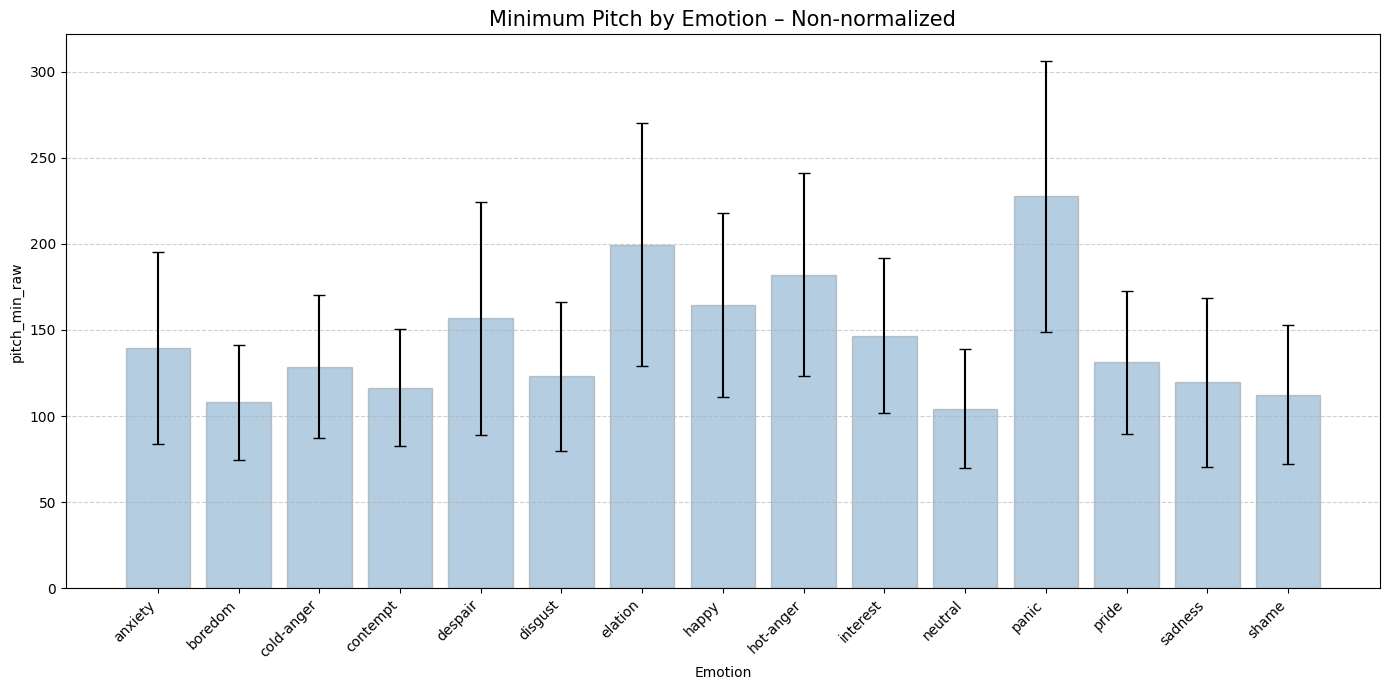

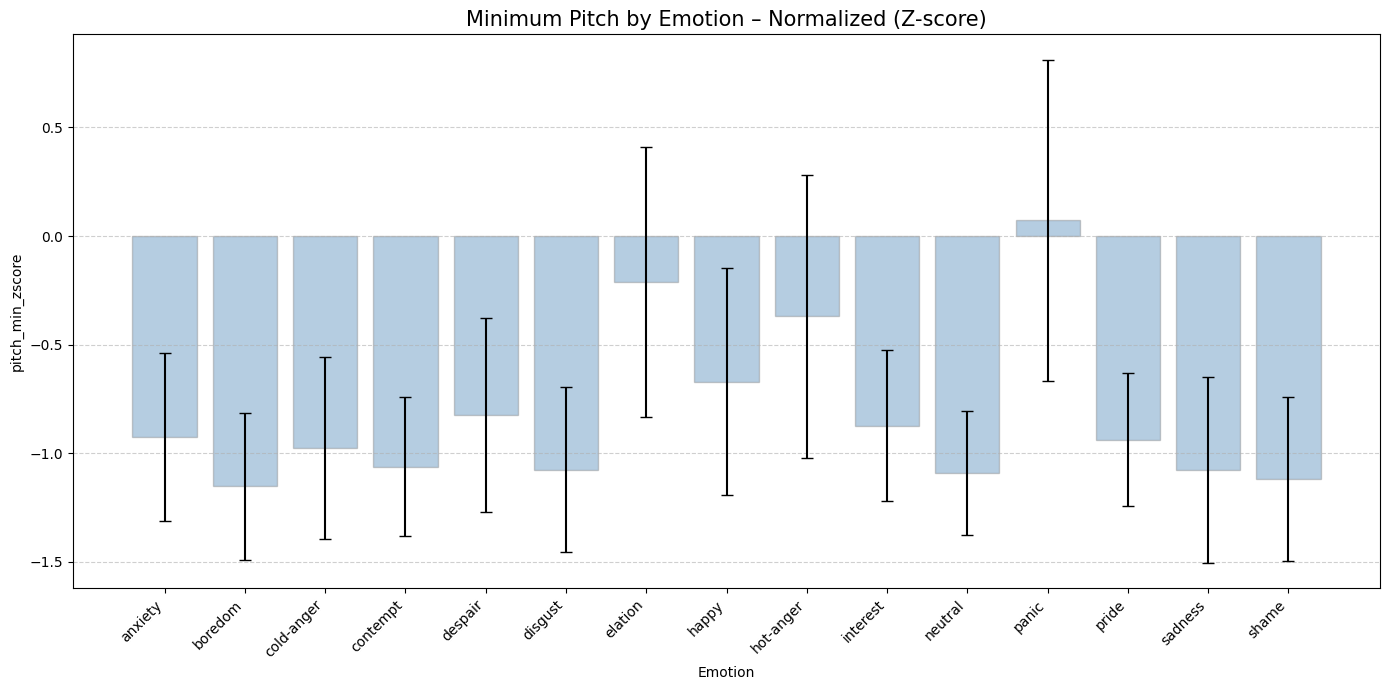

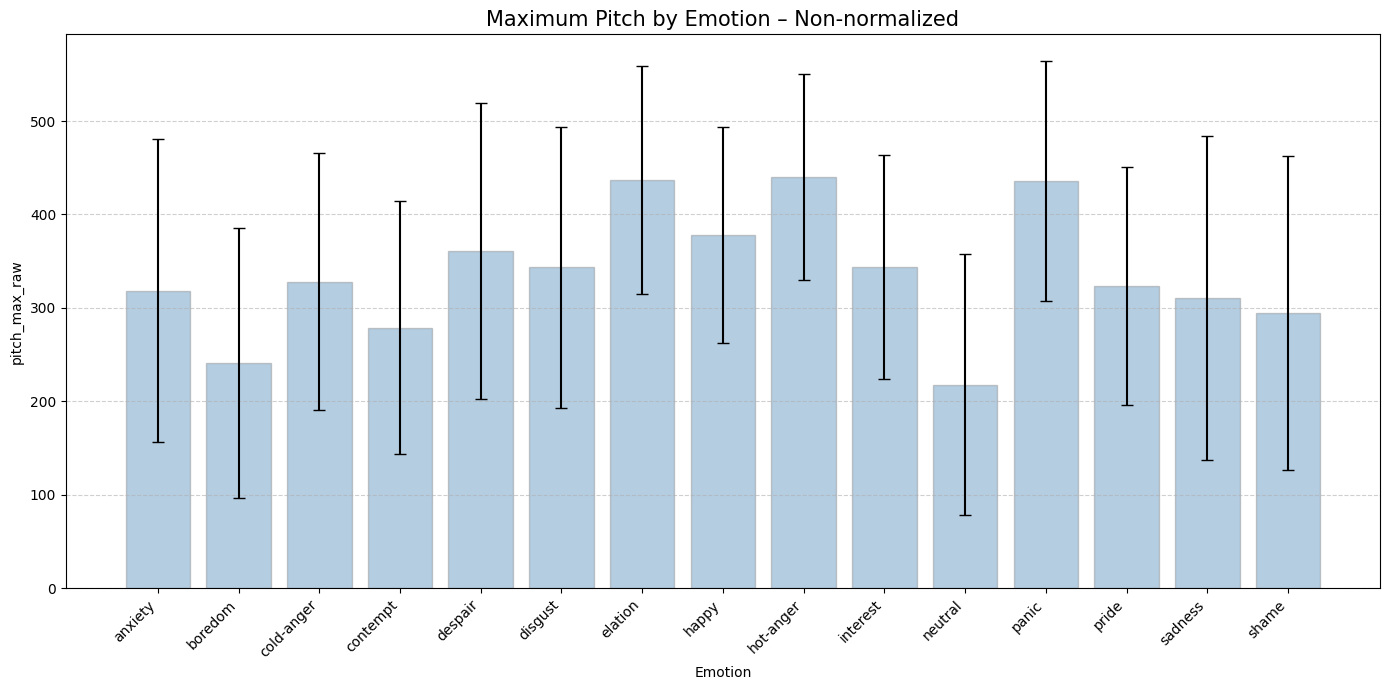

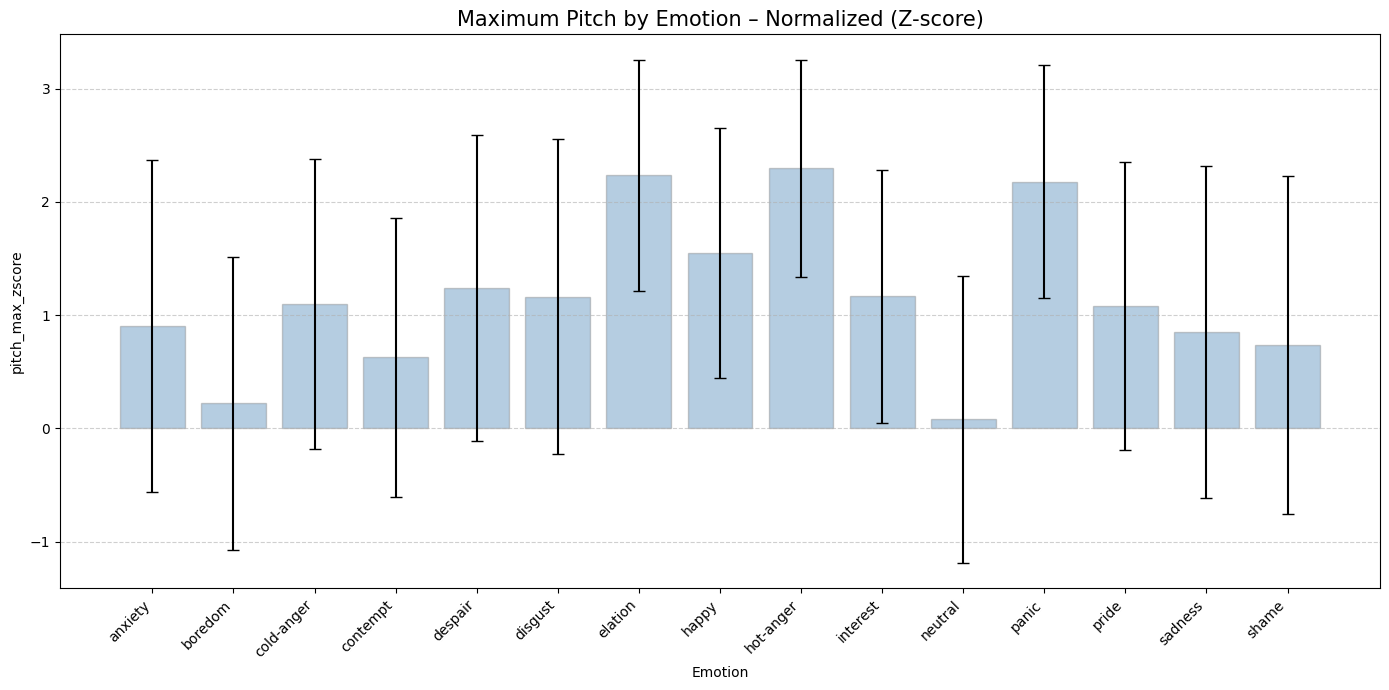

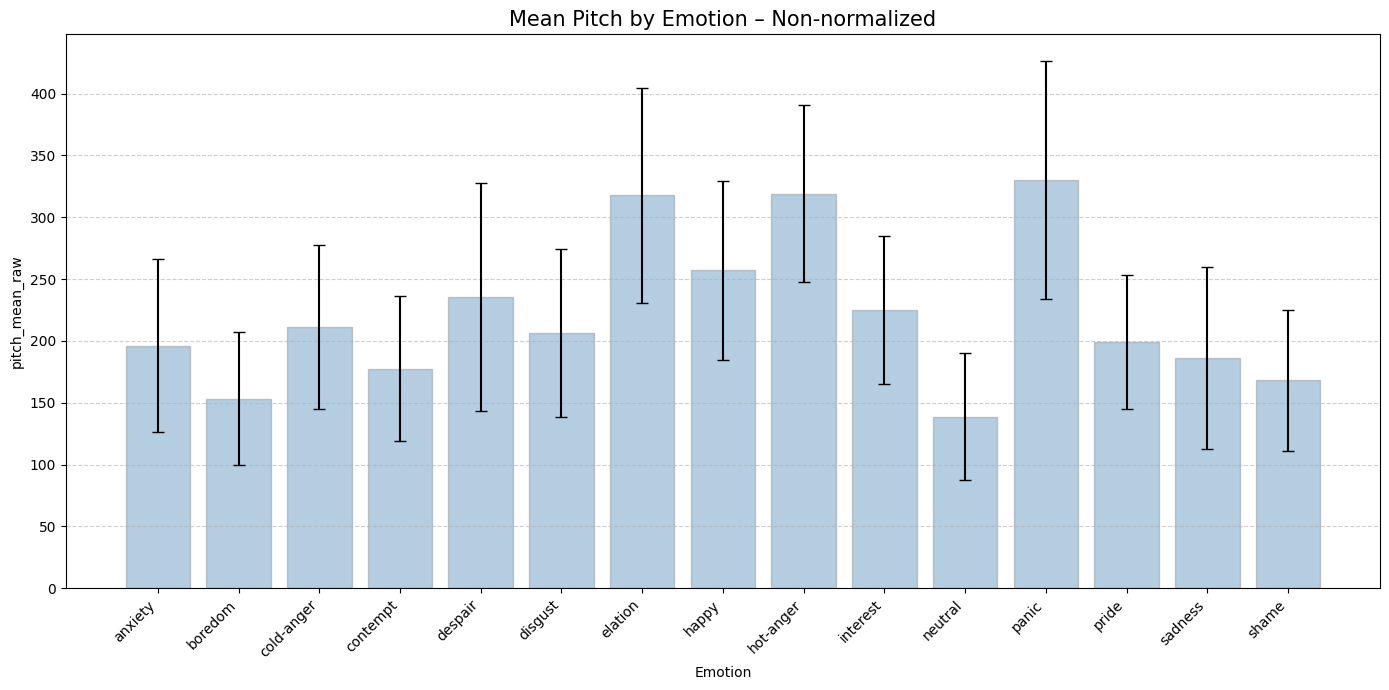

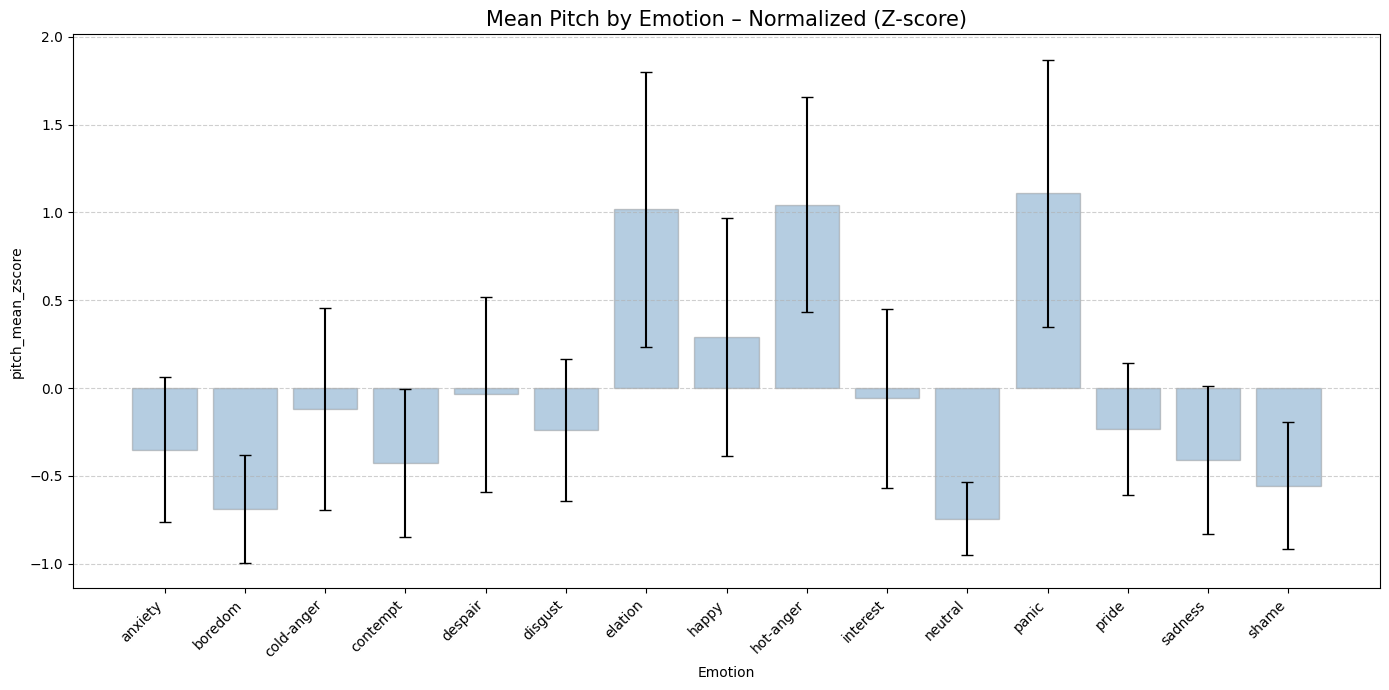

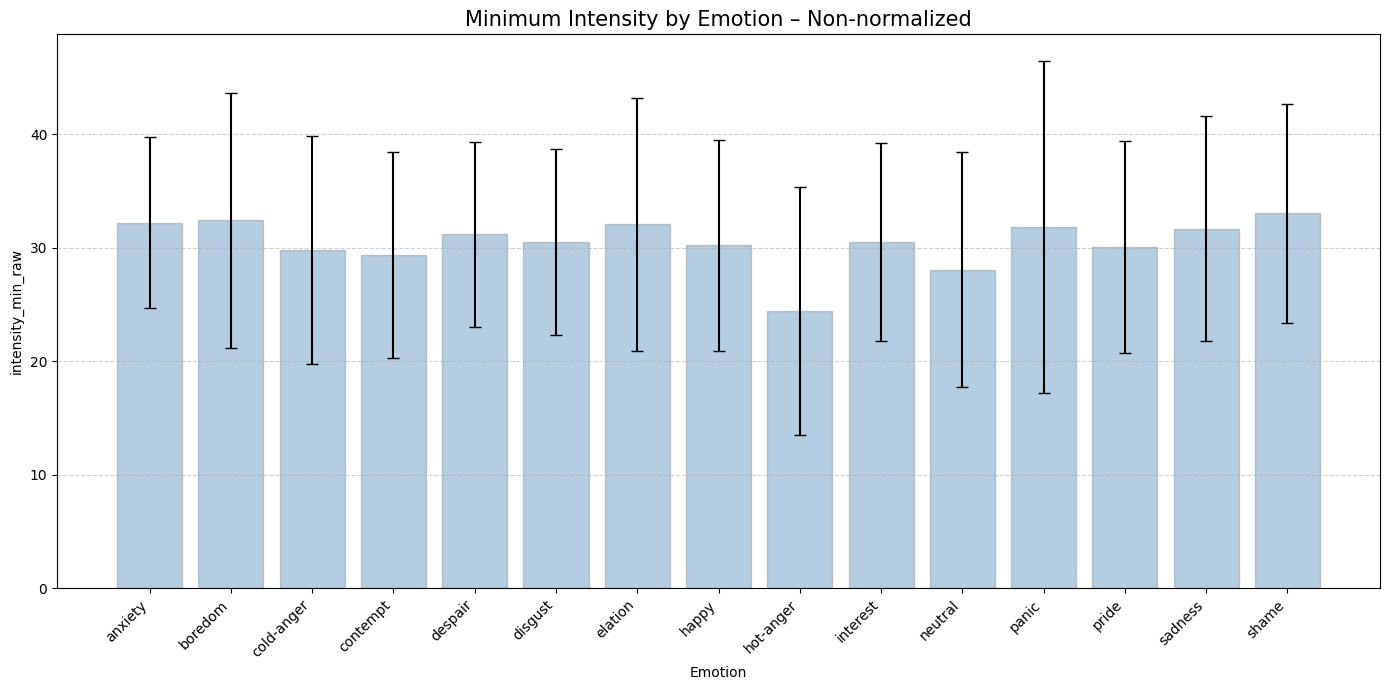

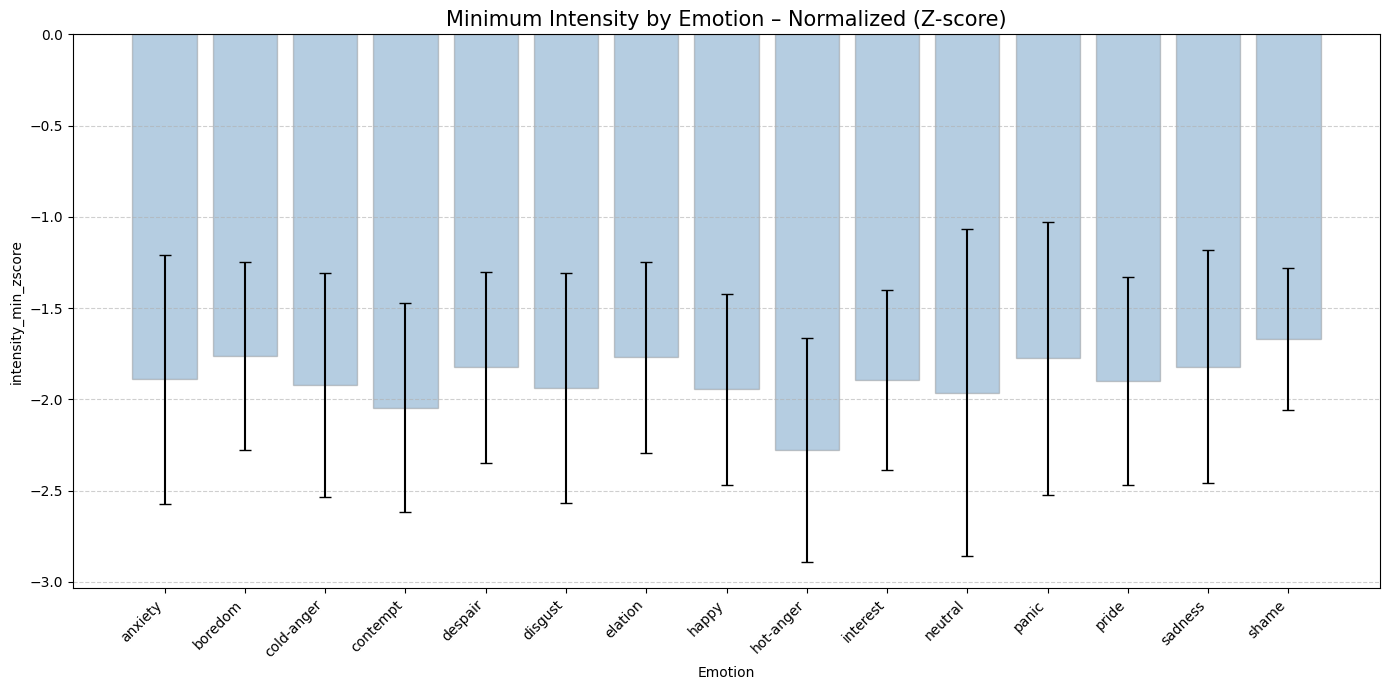

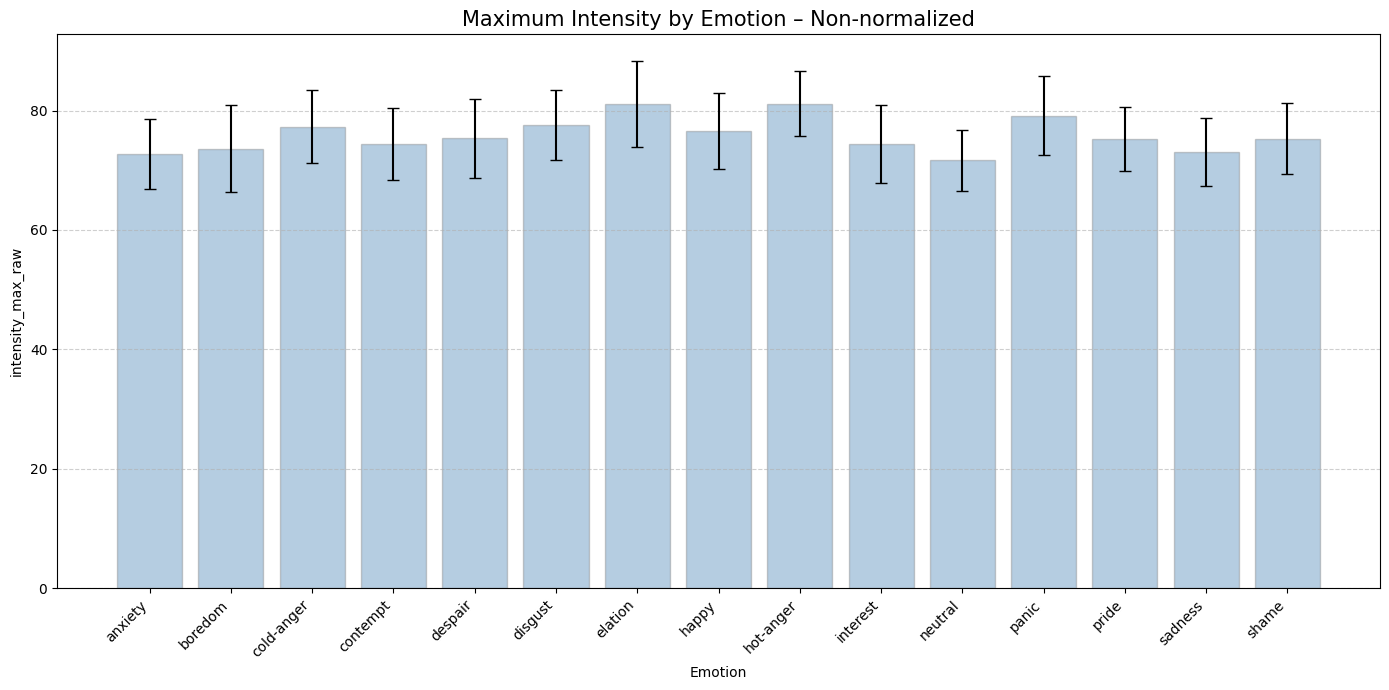

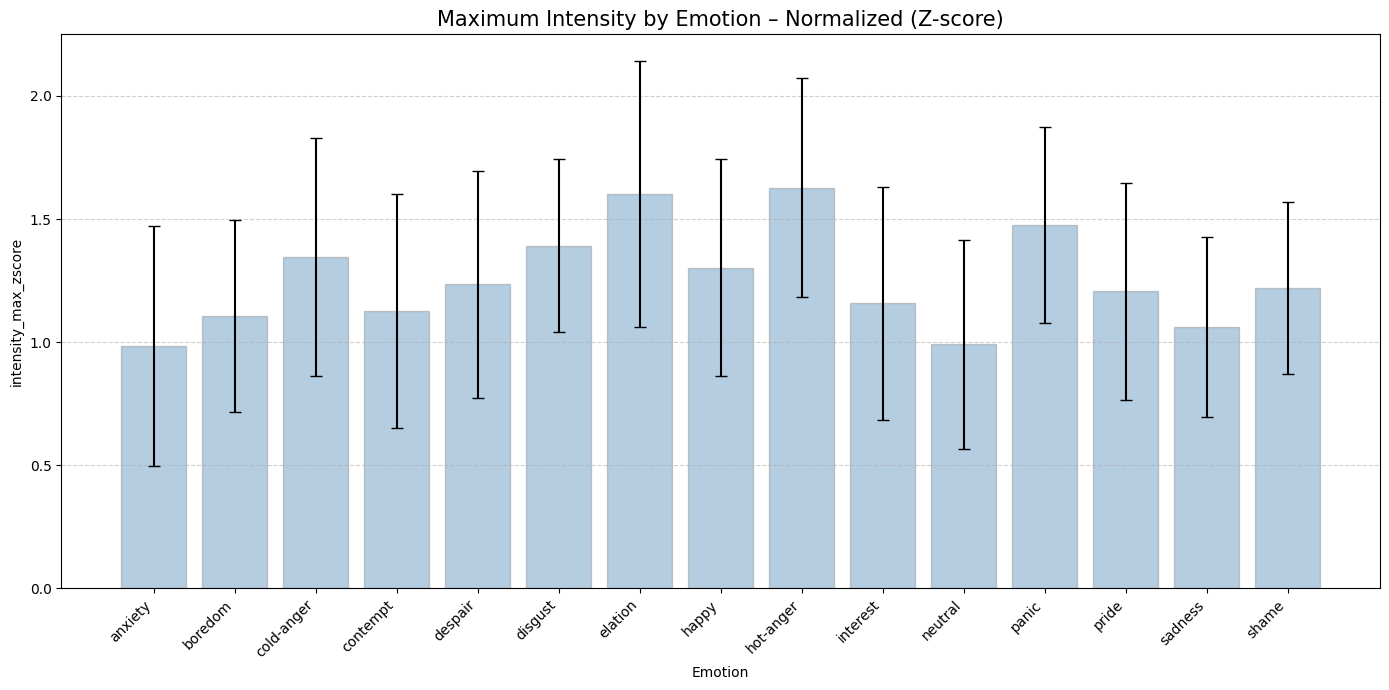

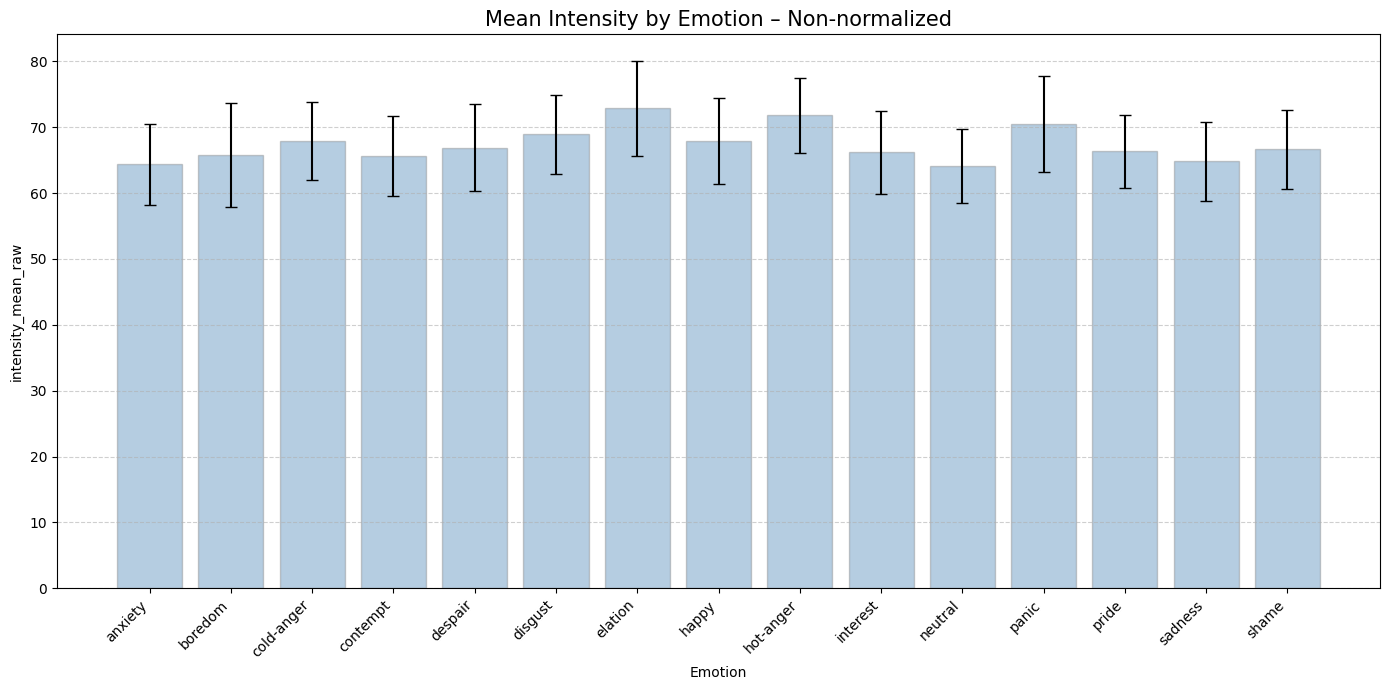

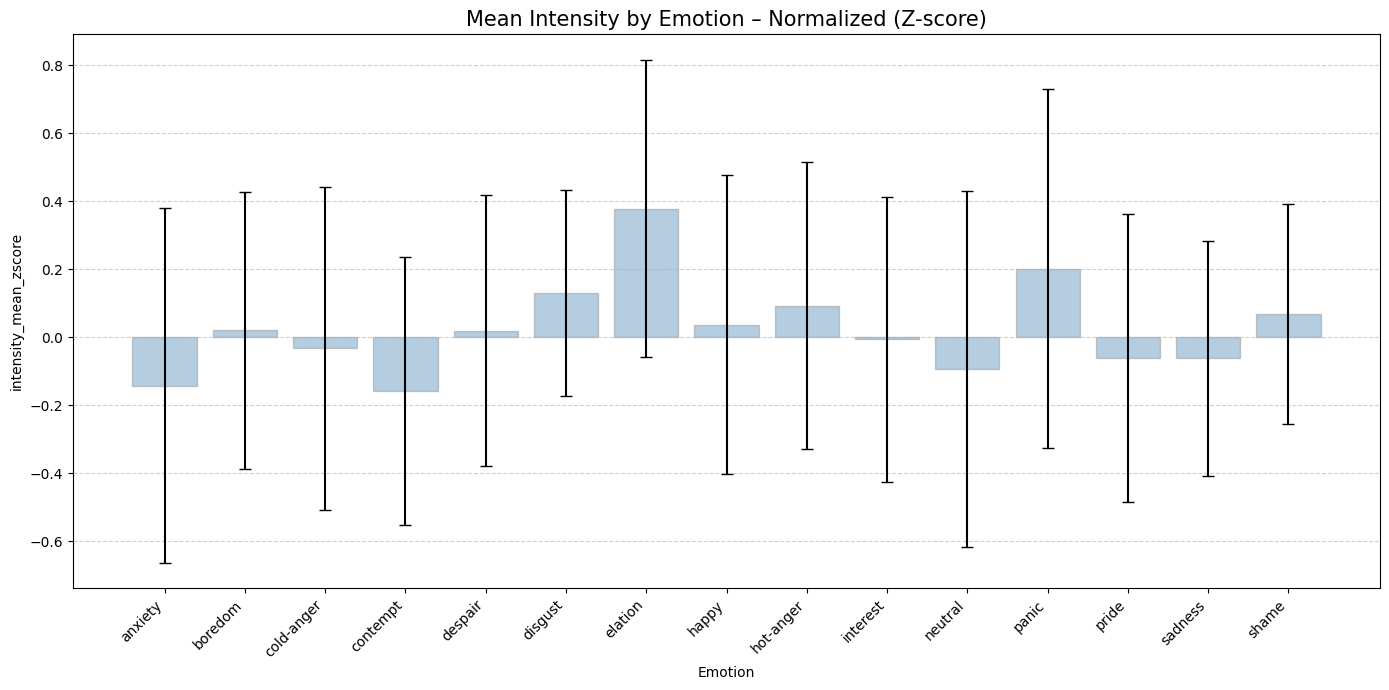

In [10]:
for raw_col, z_col, nice_name in features_map:
    plot_features(features_df, raw_col, nice_name, normalized=False)
    plot_features(features_df, z_col,  nice_name, normalized=True, method='Z-score')
